# GTI771 - Apprentissage machine avancé
## Département de génie logiciel et des technologies de l’information



## Laboratoire 5 - Régression linéaire
#### <font color=black> Version 2 - Été 2024 </font>

##### <font color=grey> Version 1 - Prof. Alessandro L. Koerich.
##### Version 2 - Chargé de lab. Arthur Josi

| NOMS                  | CODE PERMANENT  |  PARTICIPATION     |
|-----------------------|-----------------|--------------------|
| Étudiant1             | Code1           |      0%            |
| Étudiant2             | Code2           |      0%            |
| Étudiant3             | Code3           |      0%            |

## Introduction
Dans ce laboratoire, vous êtes amenés à utiliser des algorithmes de régression aﬁn de résoudre le problème de prédiction de l'âge de personnes à partir de photos du visage.

Le problème de régression qui vous est présenté est le problème [Facial Aging Estimation (FAE)](https://yanweifu.github.io/FG_NET_data/index.html), dont le but est de prédire l'âge des personnes à partir du visage. En vous basant sur les concepts vus en classe et l'expérience acquise dans le laboratoires précedents, vous êtes invité à l’extraction de primitives puis la regression de l'âge sur l’ensemble de données fourni avec cet énoncé.

##### Description de l'ensemble de données FG-NET:
* 1002 images faciales de 82 sujets multiraciaux âgés de 0 à 69 ans;
* Déséquilibré: 50% des sujets ont entre 0 et 13 ans;
* Images couleur et niveaux de gris avec largeur entre 300 et 359 pixels, hauteur entre 639 et 772 pixels, et résolution entre 200 dpi et 1200 dpi;
* Grande variation d'éclairage, de pose, d'expression faciale, de flou et d'occlusions (par exemple, moustache, barbe, lunettes, etc.).

Voici, en exemple, des images de visages se retrouvant dans l’ensemble de données FG-NET:

![Exemples de FG-NET](https://www.mdpi.com/sensors/sensors-16-00994/article_deploy/html/images/sensors-16-00994-g001.png)

L’évaluation de ce laboratoire sera basée sur:
- la qualité des algorithmes proposés et utilisés; (10%)
- utilisation du protocole et mesures de performance appropriées; (10%)
- les réponses aux questions dans ce notebook (Les cellules dans votre PDF ou votre notebook doivent être processées dans votre rendu); (70%)
- l'organisation de votre code source (n'oubliez pas de mettre des commentaires dans le code source!) (10%)

# Modules et bibliotèques python

### Import de bibliotèques

###  <font color=blue> À faire: </font>
1. Ajouter les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [46]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
import os
import re
from PIL import Image
import numpy as np
import re 
import face_recognition
import cv2
from mtcnn import MTCNN
import logging

### Définition des fonctions

In [60]:


detector = MTCNN()

logging.getLogger('tensorflow').disabled = True
logging.getLogger('mtcnn').setLevel(logging.ERROR)

def detect_faces_face_recognition(image_array):
    # Detect faces
    face_locations = face_recognition.face_locations(image_array)

    # Return 1 if faces are detected, otherwise return 0
    return 1 if len(face_locations) > 0 else 0


def detect_faces_mtcnn(image_array):
    # Initialize the MTCNN face detector

    # Detect faces
    faces = detector.detect_faces(image_array)
    return 1 if len(faces) > 0 else 0


def getId_Age_from_fileName(fileName):
    s1 = fileName.split(".")
    
    s2 = s1[0].split("A")
    s2[1] = re.sub('[^0-9]','', s2[1])
    
    id = int(s2[0])
    age = int(s2[1])

    return id, age

# Partie 1 - Lecture des images et préparation des données (40%)

Point de départ: 1002 images jpeg de l'ensemble FG-NET

## 1a: Lecture, nettoyage, prétraitement, normalisation et annotation

Différemment de l'ensemble FER, l’ensemble FG-NET consiste en un répertoire avec 1,002 images JPEG, où les étiquettes sont les noms des fichiers (âge et l'id du sujet).

Vous devez lire ces images et les représenter sous la forme d’une matrice $X\_data$ aussi que transformer les noms des fichiers dans un vecteur $Y\_data$ avec les âges et un troisième vecteur $Z\_data$ avec les id des sujets.

Vous devez également, comme vous avez déjà fait pour l'ensemble de données FER, vous assurer qu’il n'y a pas:
- données aberrantes;
- valeurs manquantes;
- valeurs inapplicables ou aberrantes;
- etc.  
PS: Pour rebalancer, ne faite pas un simple upsampling, augmentez vos données.

Finalement, vous devez également appliquer de prétraitement pour réduire la variabilité, réduire des bruits, etc. En particulier, pour les images de visage, quelques prétraitements peuvent se montrer utiles, comme:
- Localisation/recadrage du visage?
- Localisation des yeux?
- Lissage du visage?
- Normalization du contraste?
- Etc.

###  <font color=blue> À faire: </font>

1. Lire les images jpeg et les noms des fichiers et les représenter sous la forme de matrices de pixels et vecteurs de étiquettes ($X\_data$, $Y\_data$, $Z\_data$ comme décrit précédemment).

In [48]:
string = "001A002a.JPG"

id, age = getId_Age_from_fileName(string)

print("id = ", id)
print("age = ", age)

id =  1
age =  2


In [58]:
import os
import re
from PIL import Image
import numpy as np
import re 





foldername = "fgnet"
dir_list = os.listdir(foldername)
print(len(dir_list))

# Initialize the data arrays
X_data = np.zeros((len(dir_list), 256, 256, 3), dtype=np.uint8)
Y_data = np.zeros((len(dir_list), 1), dtype=int)
Z_data = np.zeros((len(dir_list), 1), dtype=int)
X_data_list = []    


dir_list.sort()

inti = 0
count = 0
for file in dir_list:
    filename = file

    id, age = getId_Age_from_fileName(filename)
    
    if id is not None and age is not None:
        Z_data[inti] = id
        Y_data[inti] = age
        
        # Open the image and resize to 256x256
        img_path = os.path.join(foldername, filename)
        with Image.open(img_path) as img:
            #img = img.resize((256, 256))
            img_array = np.array(img)

            if img_array.ndim == 2:  # Grayscale image
                img_array = np.stack((img_array,) * 3, axis=-1)
            
            if img_array.shape == (256, 256, 3):
                #X_data[inti] = img_array
                X_data_list.append(img_array)

            else:
                X_data_list.append(img_array)
               # X_data[inti] = img_array
                count += 1
                #print(f"Image shape mismatch for file: {filename}")
        
        inti +=1


print("Total images with shape mismatch: ", count)
print(X_data.shape)
print(X_data_list[0].shape)
print(Y_data.shape)
print(Z_data.shape)

for i in range(0, 10):
    print("ID = ", Z_data[i], " Age = ", Y_data[i])


1002
Total images with shape mismatch:  1002
(1002, 256, 256, 3)
(386, 321, 3)
(1002, 1)
(1002, 1)
ID =  [1]  Age =  [2]
ID =  [1]  Age =  [5]
ID =  [1]  Age =  [8]
ID =  [1]  Age =  [10]
ID =  [1]  Age =  [14]
ID =  [1]  Age =  [16]
ID =  [1]  Age =  [18]
ID =  [1]  Age =  [19]
ID =  [1]  Age =  [22]
ID =  [1]  Age =  [28]



2. Concevez et codifiez un algorithme pour vérifier l'intégrité des données, faire des corrections si nécessaires.


In [64]:
# Not sure how to do this

inti = 0
nmb = 0
bad_images = []
indexes = []
for images in X_data_list:
    #do something to check if the images are okay
    if images.shape != (256, 256, 3):
        #print("Image shape is not correct")
        pass
    if images.dtype != np.uint8:
        print("Image type is not uint8")
    if images.max() > 255 or images.min() < 0:
        print("Image pixel values are out of range")
    mean = np.mean(images)
    if mean < 0 or mean > 255:
        print("Image mean is out of range")
    if np.std(images) < 1 or np.std(images) > 255:
        print("Image std is out of range")
    if np.isnan(images).any():
        print("Image contains NaNs")
    if detect_faces_face_recognition(images) != 1:
        print("Face not detected for image", inti,  Z_data[inti], Y_data[inti])
        #plt.imshow(images)
        #plt.show()
        bad_images.append(images)
        indexes.append(inti)
        nmb += 1
    inti += 1
print("Total images with no faces detected: ", nmb)
    

for age in Y_data:
    #do something to check if the ages are okay
    if age<0 or age > 100:
        print("Age is out of range")

for id in Z_data:
    #do something to check if the ids are okay
    if id<0 or id > 1000:
        print("ID is out of range")


Face not detected for image 122 [10] [10]
Face not detected for image 168 [14] [3]
Face not detected for image 264 [22] [7]
Face not detected for image 277 [23] [3]
Face not detected for image 289 [24] [5]
Face not detected for image 299 [25] [0]
Face not detected for image 300 [25] [3]
Face not detected for image 393 [33] [2]
Face not detected for image 458 [38] [3]
Face not detected for image 526 [43] [13]
Face not detected for image 532 [44] [1]
Face not detected for image 542 [45] [3]
Face not detected for image 543 [45] [6]
Face not detected for image 545 [45] [12]
Face not detected for image 554 [45] [48]
Face not detected for image 582 [48] [0]
Face not detected for image 652 [54] [2]
Face not detected for image 684 [57] [12]
Face not detected for image 694 [58] [4]
Face not detected for image 750 [63] [8]
Face not detected for image 758 [64] [3]
Face not detected for image 791 [67] [14]
Face not detected for image 794 [67] [23]
Face not detected for image 901 [76] [0]
Face not 

In [69]:


cnt = 0
index_to_remove = []
for index, images in enumerate(bad_images):
    faces = detect_faces_mtcnn(images)
    if faces > 0:
        #print("Faces detected")
        pass
    else:
        cnt += 1
        #plt.imshow(images)
        #plt.show()
        #print("No faces detected")
        #print("Index: ", indexes[index], " ID: ", Z_data[indexes[index]], " Age: ", Y_data[indexes[index]])
        index_to_remove.insert(0, indexes[index])    

print(index_to_remove)
print("Total images with no faces detected: ", cnt)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [72]:
#Delete les images qui ne reconnaissent pas des visages

for index in index_to_remove:
    X_data_list.pop(index)
    Y_data = np.delete(Y_data, index)
    Z_data = np.delete(Z_data, index)
 
index_to_remove.clear()

print(len(X_data_list))
print(Y_data.shape)
print(Z_data.shape)


1000
(1000,)
(1000,)


3. Appliquez au moins un prétraitement sur les images de visages. Vous pouvez choisir différents algorithmes de prétraitement d’images dans [scikit-image](https://scikit-image.org/docs/stable/api/api.html) ou dans la librairie de votre choix. Vous pouvez aussi trouver d’autres types de prétraitement qui sont plus généraux dans [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing). Vous pouvez utiliser les mêmes prétraitements que ceux utilisés avec FER.


In [105]:
from sklearn.preprocessing import MinMaxScaler

# Exemple de normalisation des pixels à une plage spécifique
def normalize_image(image_array):
    scaler = MinMaxScaler()
    normalized_image = scaler.fit_transform(image_array.reshape(-1, 1)).reshape(image_array.shape)
    return normalized_image

from skimage.color import rgb2gray

# Exemple de conversion d'une image RGB en niveaux de gris
def rgb_to_gray(image_array):
    gray_image = rgb2gray(image_array)
    return gray_image

from skimage import io, exposure, filters

# Exemple d'amélioration du contraste d'une image
def enhance_contrast(image_array):
    #enhanced_image = exposure.equalize_hist(image_array, nbins=128, mask=None)
    #enhanced_image = exposure.adjust_gamma(image_array, gamma=0.8, gain=0.5)
    blurred_image = filters.gaussian(image_array, sigma=1)

    enhanced_image = exposure.equalize_adapthist(blurred_image, clip_limit=0.03, nbins=128)

    return enhanced_image


def preprocess_image(image_array):
    # Resize the image to 128x128
    
    # Normalize the image
    normalized_image = normalize_image(image_array)
    
    # Convert the image to grayscale
    grayscale_image = rgb_to_gray(normalized_image)
    
    # Enhance the contrast of the image
    contrast_image = enhance_contrast(grayscale_image)
    
    return contrast_image

X_data_processed = []
for image in X_data_list:
    image2 = preprocess_image(image)
    X_data_processed.append(image2)


    

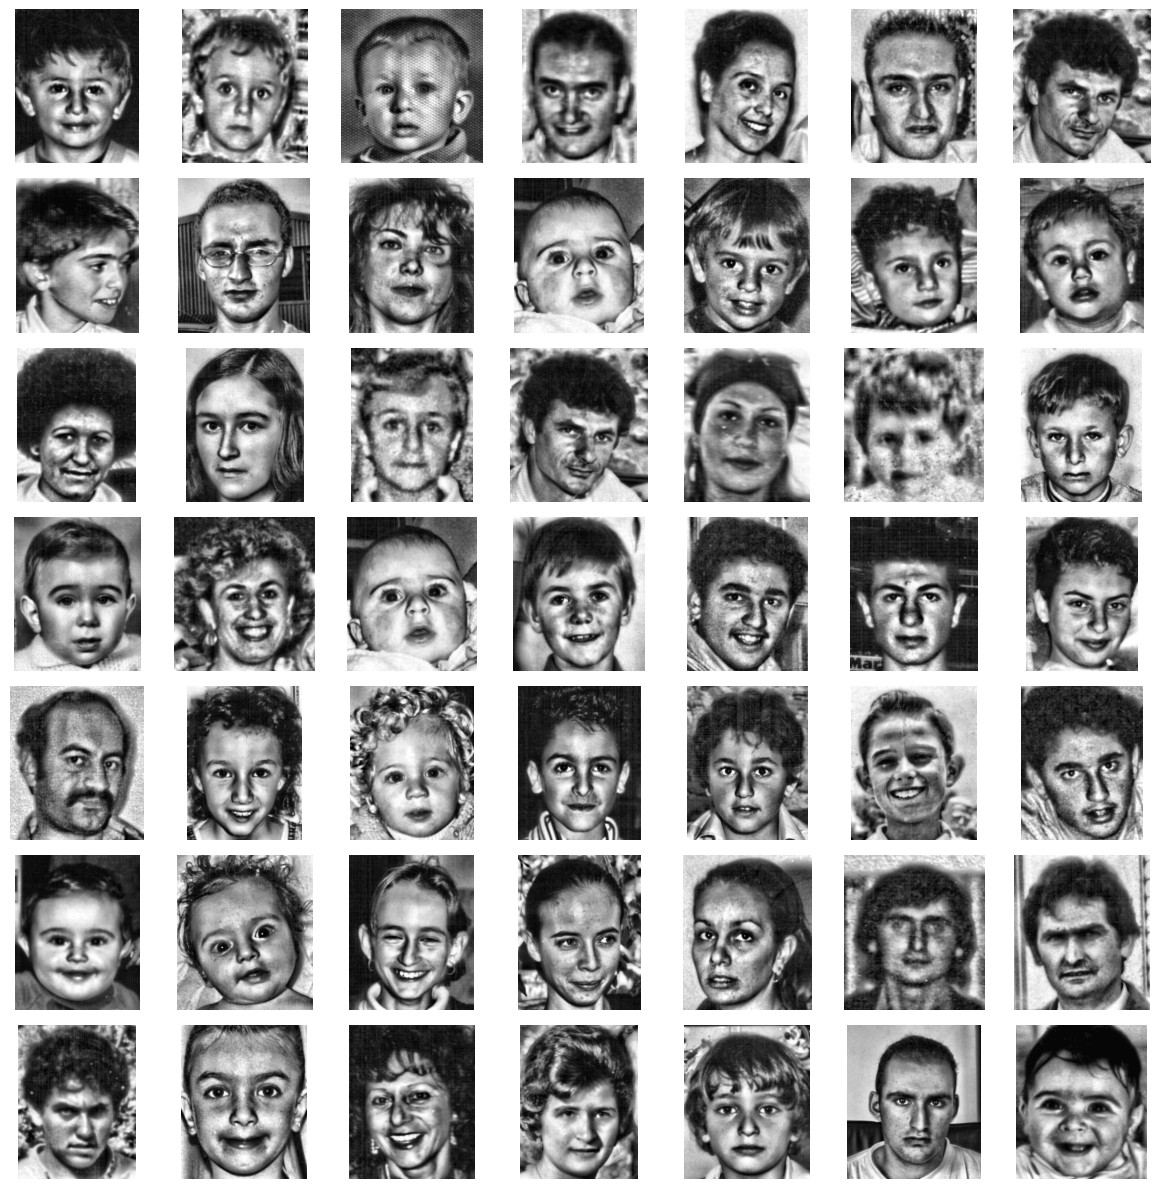

In [100]:
# Create a figure with a larger size
plt.figure(figsize=(12, 12))

# Plotting each image in a 7x7 grid
num_rows = 7
num_cols = 7

for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    random_index = np.random.randint(0, len(X_data_list))
    plt.imshow(X_data_processed[random_index], cmap='gray')
    plt.axis('off')

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

4. Choisir et appliquer une résolution $n\times m$ qui vous semble pertinente pour normaliser les images, car celles-ci n'ont pas toutes la même résolution.

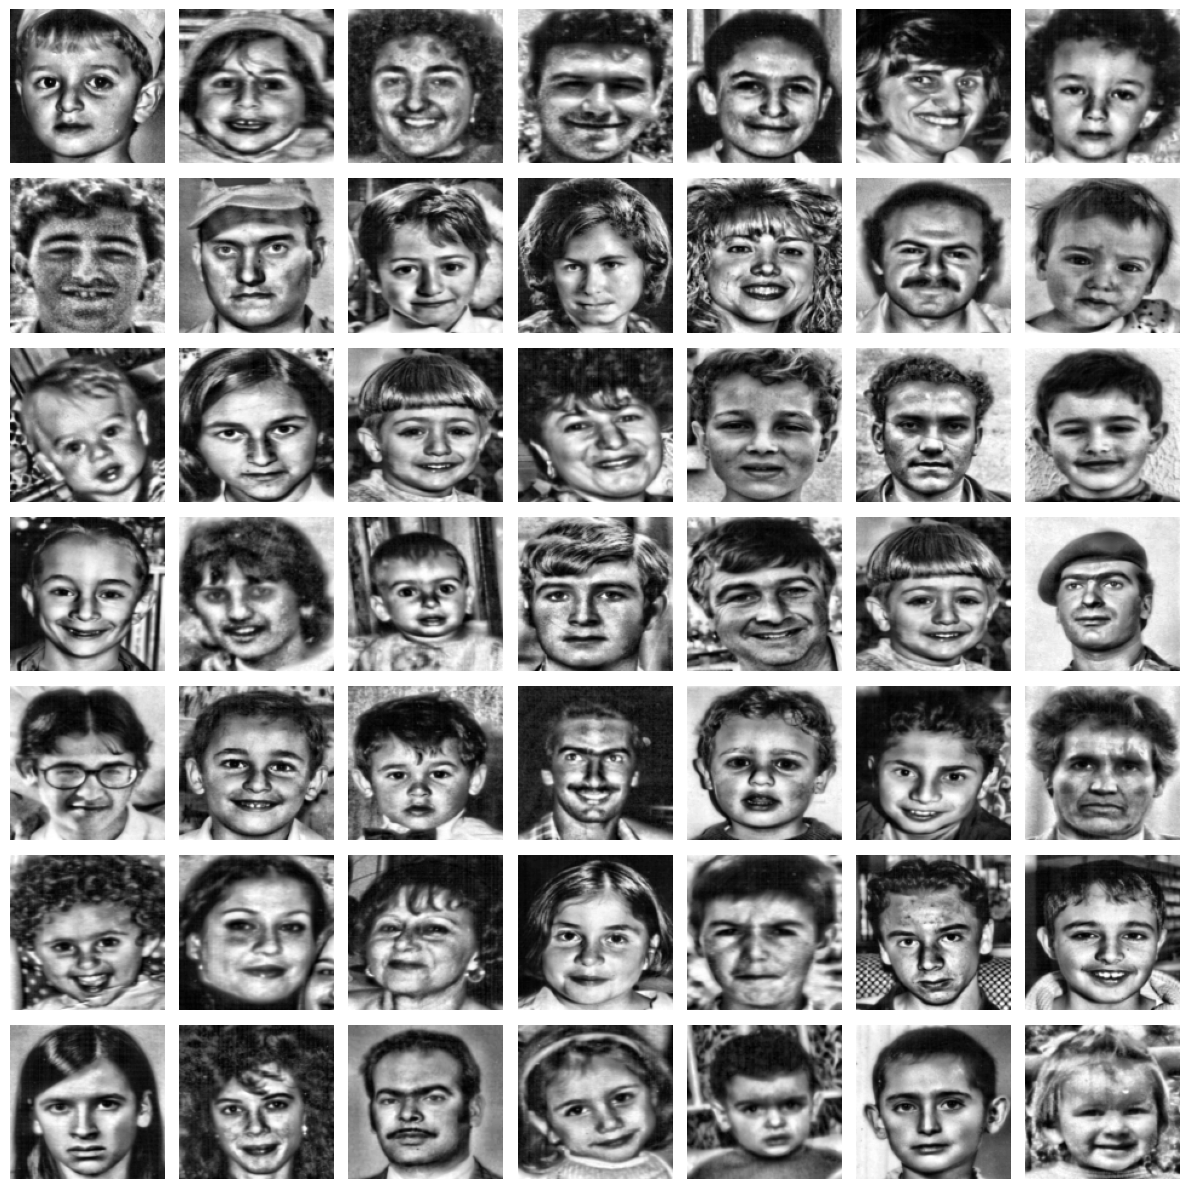

In [114]:
from skimage import io, transform

resolution = 128

def resize_image(image, new_height=resolution, new_width=resolution):
    resized_image = transform.resize(image, (new_height, new_width))
    return resized_image


X_data_resized = []
for image in X_data_processed:
    resized_image = resize_image(image)
    X_data_resized.append(resized_image)





def show_images(images, num_rows, num_cols, figsize=(12, 12)):
    plt.figure(figsize=figsize)
    for i in range(num_rows * num_cols):
        random_indexes = np.random.randint(0, len(images))
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[random_indexes], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


show_images(X_data_resized, 7, 7, figsize=(12, 12))


5. Transformez toutes les images afin que celles-ci soient toutes définies sur les 3 canaux (RGB).


In [120]:
#Deja fait 

X_data_3channels = []   
for image in X_data_resized:
    image = np.stack((image,) * 3, axis=-1)
    X_data_3channels.append(image)


for i in range (10):
    print(X_data_3channels[i].shape)

X_data_3channels = np.array(X_data_3channels, dtype=np.float32)


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


In [124]:
X_data_3channels = np.array(X_data_3channels, dtype=np.float32)
print(X_data_3channels.shape)
print(Y_data.shape)
print(Z_data.shape)


print(X_data_3channels[0])

(1000, 128, 128, 3)
(1000,)
(1000,)
[[[0.26697668 0.26697668 0.26697668]
  [0.23177408 0.23177408 0.23177408]
  [0.2367181  0.2367181  0.2367181 ]
  ...
  [0.6831952  0.6831952  0.6831952 ]
  [0.67158186 0.67158186 0.67158186]
  [0.64907473 0.64907473 0.64907473]]

 [[0.26693696 0.26693696 0.26693696]
  [0.23173763 0.23173763 0.23173763]
  [0.2333268  0.2333268  0.2333268 ]
  ...
  [0.6604217  0.6604217  0.6604217 ]
  [0.6646979  0.6646979  0.6646979 ]
  [0.65032446 0.65032446 0.65032446]]

 [[0.2527039  0.2527039  0.2527039 ]
  [0.22070962 0.22070962 0.22070962]
  [0.2373535  0.2373535  0.2373535 ]
  ...
  [0.6665504  0.6665504  0.6665504 ]
  [0.67744446 0.67744446 0.67744446]
  [0.6665382  0.6665382  0.6665382 ]]

 ...

 [[0.9585738  0.9585738  0.9585738 ]
  [0.8179591  0.8179591  0.8179591 ]
  [0.5587295  0.5587295  0.5587295 ]
  ...
  [0.8760505  0.8760505  0.8760505 ]
  [0.9036682  0.9036682  0.9036682 ]
  [0.9430425  0.9430425  0.9430425 ]]

 [[0.8889844  0.8889844  0.8889844 ]
 

6. Générez un fichier *fg-net-nxm.csv* avec les données nettoyées et normalisées, où $n$ et $m$ représentent la résolution finale des images.
   - Format du fichier: subject,age,pixels
      * sujet: integer
      * âge: integer
      * pixels: integer [0, 255]

In [146]:
import numpy as np
import pandas as pd
from skimage import color
from PIL import Image
import os


data = []


for i in range(len(X_data_resized)):
    img_gray = X_data_list[i]

    img_rgb = X_data_3channels[i]

    # Flatten the image channels
 
    ch_ = img_rgb.flatten()
    # Flatten the image channels

    ch_str = ' '.join(map(str, ch_))

    
    # Combine id, age, and flattened pixel data
    row = [Z_data[i], Y_data[i] ,ch_str]
    data.append(row)

# Create a DataFrame
columns = ['id', 'age', 'pixels']
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv('image_data.csv', index=False)


In [149]:

#Check to see that everything is okay
ferData = pd.read_csv('image_data.csv', delimiter=',', dtype={'id': int, 'age': int, 'pixels': str})


Z_data = ferData['id'].values
Y_data = ferData['age'].values

X_pixel = ferData['pixels'].values
X_split_pixel = [x.split(" ") for x in X_pixel]

print(len(X_split_pixel[0]))

X_pixel = np.array(X_split_pixel, dtype='float32')
X_pixel = X_pixel.reshape(X_pixel.shape[0], resolution, resolution, 3)

print(X_pixel.shape)



49152
(1000, 128, 128, 3)


In [145]:
print(128*128*3)

49152


7. Décrivez brièvement les étapes de votre algorithme/code.

8. Créer une grille de dimension 7$\times$2 avec des images de visage prises aléatoirement de l'ensemble FG-NET original et après vos traitements. Afficher également l'âge et le id du sujet au dessus de chaque image.

# Partie 2 - Extraction de primitives (10%)

###  <font color=blue> À faire: </font>
1. Choisir et extraire un jeu de primitives pour représenter les images de FG-NET. Vous êtes fortement conseillé de choisir
le jeu de primitives les plus performants dans les TPs précédents (primitives artisanaux, deep, deep réduit, etc.)

2. Sauvegardez vos vecteurs de primitives sous la forme d'un fichier 'csv' (p. ex. *fgnet-deepVGG19.csv*). N'oubliez pas d'utiliser toujours la même structure du fichier *fg-net-nxm.csv* de 1a). Vous devez nommer vos fichiers de primitives en référence au jeu de primitives utilisé, p. ex., *fg-net-12x12-deepVGG19.csv* pour des primitives produites avec une CNN VGG19.


3. Décrivez très brièvement le choix du jeu de primitives.

# Partie 3: Entraînement de modèles de régression (20%)

Vous êtes maintenant prêtes à entraîner un modèle d'apprentissage automatique avec les vecteurs de primitives extraits dans la Partie 2.

###  <font color=blue> À faire: </font>
1. Choisir deux (2) algorithmes de régression disponibles dans Scikit-learn:
    * Régression lineaire
    * Régression Ridge
    * Régression Lasso et Elastic-Net
    * Descente du gradiente stochastique (SGD)<br>

Conseil: Étudiez les algorithmes choisis pour bien comprendre les différents hyperparamètres qui peuvent affecter l'entraînement, la généralisation et la complexité du modèle de régression.

Algorithmes choisis: \<ici\>

2. Entraîner et optimiser les paramètres des modèles de régression. Utiliser le protocole <font color=blue> "Leave One Subject Out Cross-Validation" </font> (LOSO).

3. Étudiez les metriques d'évaluation des modèles de régression disponibles dans [Scikit-Learn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) puis utilisez MSE, MAE et une troisième metrique de votre choix.


4. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur les algorithmes de régression choisis.

| Algorithme            | Paramètres    |  MSE  |  MAE  | \<votre choix\> |
|-----------------------|---------------|-------|-------|-------|
| Regr lineaire         | XXX.XX        |XXX.XX |XXX.XX |       |
| Regr Ridge            | alpha = 0.1   |123.34 | 10.45 |       |
| Regr Lasso            | XXX.XX        |XXX.XX |XXX.XX |       |
| Regr ElasticNet       | XXX.XX        |XXX.XX |XXX.XX |       |
| ...                   | XXX.XX        |XXX.XX |XXX.XX |       |
| ...                   | XXX.XX        |XXX.XX |XXX.XX |       |

# Fin